[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/asteroid-team/asteroid/blob/master/notebooks/00_GettingStarted.ipynb)

## About Asteroid

Asteroid is an open-source, community-based toolkit made to design, train, evaluate, use and share audio source separation models such as Deep clustering ([Hershey et al.](https://arxiv.org/abs/1508.04306)), ConvTasNet ([Luo et al.](https://arxiv.org/abs/1809.07454)) DPRNN ([Luo et al.](https://arxiv.org/abs/1910.06379)) etc...

## About this tutorial

In this tutorial you will learn to:

- Perform speech separation inference using a pretrained model.
- Run a very simple training on a tiny dataset.

Training models on a larger dataset/your own data and writing your own models will be explained in another tutorial.

## Install Asteroid

Install Asteroid to get started:

In [1]:
%%capture
!pip install -U asteroid

## Pretrained model speech separation

Asteroid comes with [pretrained models](https://huggingface.co/models?filter=asteroid) that help you get started quickly, like the 8 kHz [DPRNN](https://huggingface.co/mpariente/DPRNNTasNet-ks2_WHAM_sepclean).

As an example audio file to separate, you can use a mixture from the Deep clustering paper. Let's download it and listen to the unseparated version:

In [3]:
import musdb
mus = musdb.DB(download=True)
track = mus[42]

In [4]:
from IPython.display import display, Audio

Audio(track.audio.T, rate=track.rate)

### Separate using the `asteroid-infer` CLI

The `asteroid-infer` command will download a model from the Hugging Face model hub and run separation on each of the files given, creating 2 estimated sources `_est1.wav` and `_est2.wav`:

In [5]:
!asteroid-infer "mpariente/DPRNNTasNet-ks2_WHAM_sepclean" --files female-female-mixture.wav
!echo "-----"
!ls

-----
female-female-mixture_est1.wav	female-female-mixture.wav
female-female-mixture_est2.wav	sample_data


In [6]:
display(Audio("female-female-mixture_est1.wav"))
display(Audio("female-female-mixture_est2.wav"))

### Separate in Python

You can also run separation using Python code.

In [18]:
track.audio.shape

(300032, 2)

In [22]:
np.transpose(track.audio, (1, 0)).reshape(1, 2, 300032).shape

(1, 2, 300032)

In [24]:
mixture.reshape(1, 1, -1).shape

(1, 1, 2)

In [47]:
import librosa
import numpy as np
import soundfile as sf
from asteroid.models import BaseModel, ConvTasNet

# 'from_pretrained' automatically uses the right model class (asteroid.models.DPRNNTasNet).
model = ConvTasNet.from_pretrained('JorisCos/ConvTasNet_Libri2Mix_sepclean_8k')
# model = BaseModel.from_pretrained("mpariente/DPRNNTasNet-ks2_WHAM_sepclean")

# You can pass a NumPy array:
mixture = librosa.to_mono(track.audio.T)
# Soundfile returns the mixture as shape (time, channels), and Asteroid expects (batch, channels, time)
mixture = mixture.reshape(1, 1, -1).astype(np.float32)
out_wavs = model.separate(mixture)

Downloading: 100%|██████████| 20.3M/20.3M [00:01<00:00, 17.0MB/s]


# Libri2Mix :
1. Load data with the asteroid Libri2Mix class
2. Load a sample (x = the mixture (shape: (T,)) and y = the target sources (shape : (T, 2)))
3. Infer with asteroid model

In [51]:
from asteroid.data import LibriMix
LibriMix.mini_download()

'./MiniLibriMix/metadata'

In [52]:
data = LibriMix('./MiniLibriMix/metadata', task='sep_clean', sample_rate=16000, n_src=2, segment=3, return_id=False)

Drop 143 utterances from 200 (shorter than 3 seconds)


In [58]:
x, y = data.__getitem__(0)

In [59]:
x.shape

torch.Size([48000])

In [60]:
y.shape

torch.Size([2, 48000])

In [62]:
import librosa
import numpy as np
import soundfile as sf
from asteroid.models import BaseModel, ConvTasNet

# 'from_pretrained' automatically uses the right model class (asteroid.models.DPRNNTasNet).
model = ConvTasNet.from_pretrained('JorisCos/ConvTasNet_Libri2Mix_sepclean_8k')
# model = BaseModel.from_pretrained("mpariente/DPRNNTasNet-ks2_WHAM_sepclean")

# You can pass a NumPy array:
mixture = x
# Soundfile returns the mixture as shape (time, channels), and Asteroid expects (batch, channels, time)
mixture = mixture.reshape(1, 1, -1)
out_wavs = model.separate(mixture)

In [82]:
model.get_model_args()

{'fb_name': 'FreeFB',
 'n_filters': 512,
 'kernel_size': 16,
 'stride': 8,
 'sample_rate': 8000.0,
 'in_chan': 512,
 'out_chan': 512,
 'bn_chan': 128,
 'hid_chan': 512,
 'skip_chan': 128,
 'conv_kernel_size': 3,
 'n_blocks': 8,
 'n_repeats': 3,
 'n_src': 2,
 'norm_type': 'gLN',
 'mask_act': 'relu',
 'causal': False,
 'encoder_activation': None}

In [84]:
model.get_state_dict()['encoder.filterbank._filters'].shape

torch.Size([512, 1, 16])

In [85]:
model.get_state_dict()['masker.bottleneck.1.weight'].shape

torch.Size([128, 512, 1])

In [87]:
model.get_state_dict()['masker.bottleneck.1.bias'].shape

torch.Size([128])

In [89]:
model.get_state_dict()['decoder.filterbank._filters'].shape

torch.Size([512, 1, 16])

In [95]:
model.get_state_dict()['masker.mask_net.1.weight'].shape

torch.Size([1024, 128, 1])

In [92]:
model.get_state_dict()['masker.mask_net.1.bias'].shape

torch.Size([1024])

In [83]:
model.get_state_dict().keys()

odict_keys(['encoder.filterbank._filters', 'masker.bottleneck.0.gamma', 'masker.bottleneck.0.beta', 'masker.bottleneck.1.weight', 'masker.bottleneck.1.bias', 'masker.TCN.0.shared_block.0.weight', 'masker.TCN.0.shared_block.0.bias', 'masker.TCN.0.shared_block.1.weight', 'masker.TCN.0.shared_block.2.gamma', 'masker.TCN.0.shared_block.2.beta', 'masker.TCN.0.shared_block.3.weight', 'masker.TCN.0.shared_block.3.bias', 'masker.TCN.0.shared_block.4.weight', 'masker.TCN.0.shared_block.5.gamma', 'masker.TCN.0.shared_block.5.beta', 'masker.TCN.0.res_conv.weight', 'masker.TCN.0.res_conv.bias', 'masker.TCN.0.skip_conv.weight', 'masker.TCN.0.skip_conv.bias', 'masker.TCN.1.shared_block.0.weight', 'masker.TCN.1.shared_block.0.bias', 'masker.TCN.1.shared_block.1.weight', 'masker.TCN.1.shared_block.2.gamma', 'masker.TCN.1.shared_block.2.beta', 'masker.TCN.1.shared_block.3.weight', 'masker.TCN.1.shared_block.3.bias', 'masker.TCN.1.shared_block.4.weight', 'masker.TCN.1.shared_block.5.gamma', 'masker.TCN.

Text(0.5, 1.0, 'Speaker 2 target')

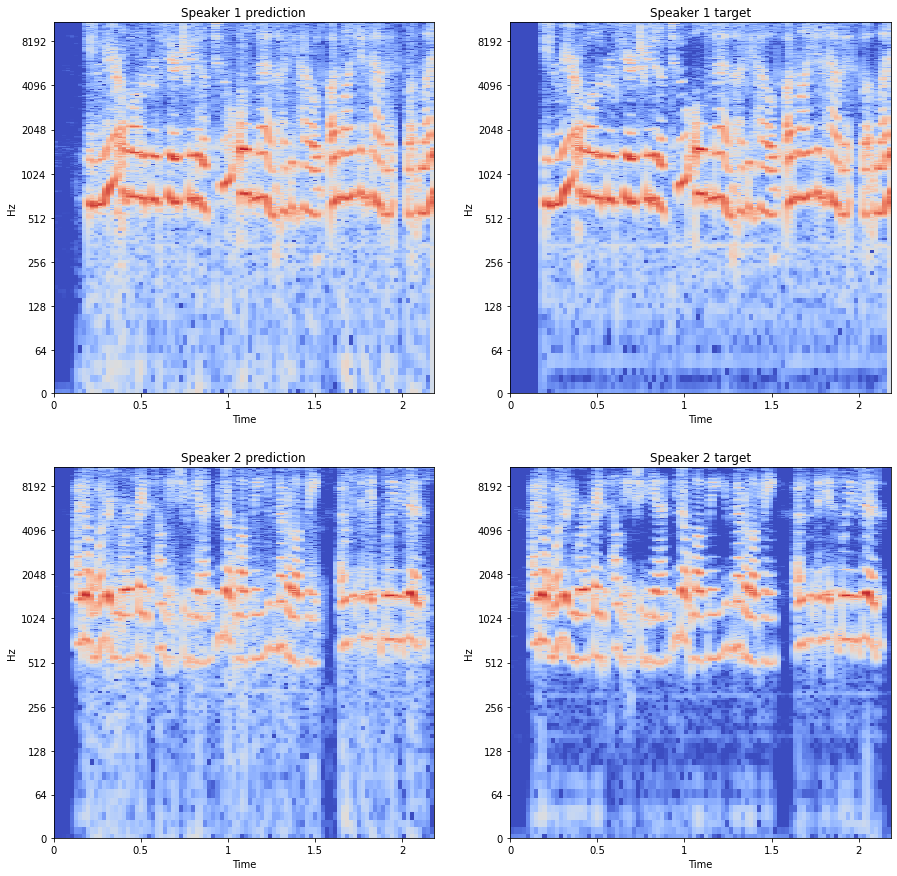

In [67]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
show_magspec(out_wavs[0, 0, :], ax=axes[0, 0])
show_magspec(y[0, :], ax=axes[0, 1])
show_magspec(out_wavs[0, 1, :], ax=axes[1, 0])
show_magspec(y[1, :], ax=axes[1, 1])
axes[0, 0].set_title("Speaker 1 prediction")
axes[0, 1].set_title("Speaker 1 target")
axes[1, 0].set_title("Speaker 2 prediction")
axes[1, 1].set_title("Speaker 2 target")

In [71]:
out_wavs[0, 1, :].shape

torch.Size([48000])

In [72]:
y[1, :].shape

torch.Size([48000])

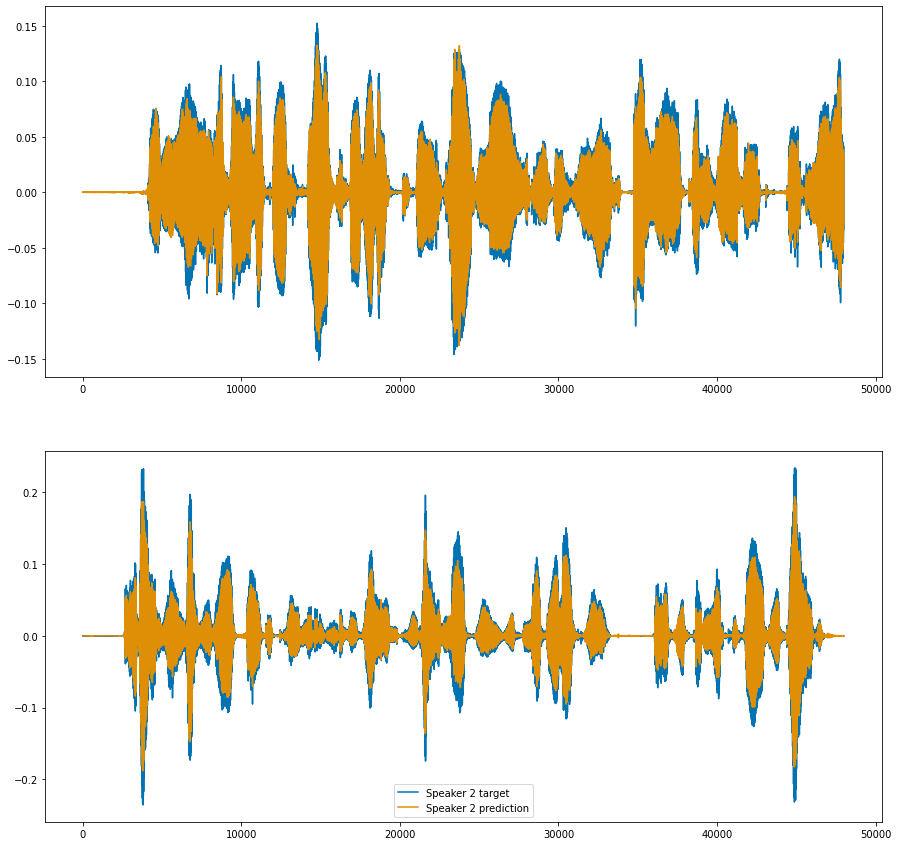

In [81]:
import seaborn as sns
colors = sns.color_palette('colorblind')

fig, axes = plt.subplots(2, 1, figsize=(15, 15))
axes[0].plot(y[0, :], label="Speaker 1 target", color=colors[0])
axes[0].plot(out_wavs[0, 0, :], label="Speaker 1 prediction", color=colors[1])
axes[1].plot(y[1, :], label="Speaker 2 target", color=colors[0])
axes[1].plot(out_wavs[0, 1, :], label="Speaker 2 prediction", color=colors[1])
plt.legend()
plt.show()

Les signaux prédits et cibles ressemblent à peu près à la même chose : mais on remarque qu'il peut y avoir un petit décalage temporel : la phase ? Ce n'est pas très grave ce décalage puisque l'on a quand même restitué le contenu, c'est le principal.

## Question :
Comment sait-on quel signal appartient à quel interlocuteur ? (permutation problem)

### Visualize the results

You can visualize the separation results as magnitude spectrograms:

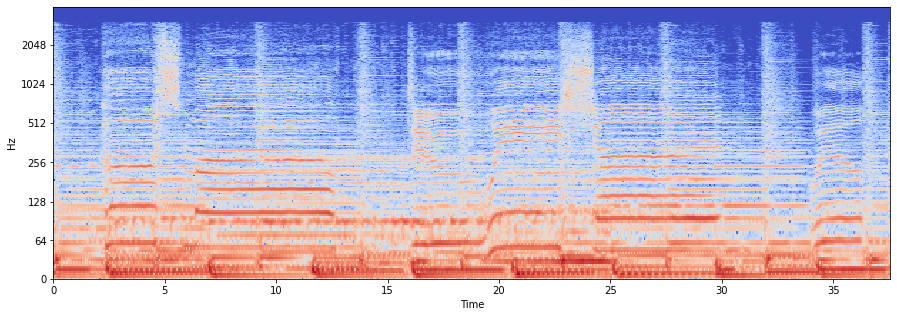

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display


def show_magspec(waveform, to_mono=False, **kw):
    return librosa.display.specshow(
        librosa.amplitude_to_db(
            np.abs(
                librosa.stft(
                    librosa.to_mono(
                        waveform
                        )
                    )
                )
            ),
            y_axis="log", x_axis="time",
            **kw
    )

fig = plt.figure(figsize=(15, 5))
show_magspec(track.audio.T, to_mono=True, sr=8000)

## Train your own model

Asteroid makes it easy to train your own models. In this tutorial you will learn the absolute minimum required to perform a simplistic training on a tiny dataset. Training a high-quality model is more involved and will be explained in another tutorial.

Run the code below to perform the training. It should take around 1 minute per epoch on Google Colab.

While the training runs, read through the code comments below!

In [ ]:
# Asteroid is based on PyTorch and PyTorch-Lightning.
from torch import optim
from pytorch_lightning import Trainer

# We train the same model architecture that we used for inference above.
from asteroid.models import DPRNNTasNet

# In this example we use Permutation Invariant Training (PIT) and the SI-SDR loss.
from asteroid.losses import pairwise_neg_sisdr, PITLossWrapper

# MiniLibriMix is a tiny version of LibriMix (https://github.com/JorisCos/LibriMix),
# which is a free speech separation dataset.
from asteroid.data import LibriMix

# Asteroid's System is a convenience wrapper for PyTorch-Lightning.
from asteroid.engine import System

# This will automatically download MiniLibriMix from Zenodo on the first run.
train_loader, val_loader = LibriMix.loaders_from_mini(task="sep_clean", batch_size=16)

# Tell DPRNN that we want to separate to 2 sources.
model = DPRNNTasNet(n_src=2)

# PITLossWrapper works with any loss function.
loss = PITLossWrapper(pairwise_neg_sisdr, pit_from="pw_mtx")

optimizer = optim.Adam(model.parameters(), lr=1e-3)

system = System(model, optimizer, loss, train_loader, val_loader)

# Train for 1 epoch using a single GPU. If you're running this on Google Colab,
# be sure to select a GPU runtime (Runtime → Change runtime type → Hardware accelarator).
trainer = Trainer(max_epochs=1, gpus=1)
trainer.fit(system)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Drop 0 utterances from 800 (shorter than 3 seconds)
Drop 0 utterances from 200 (shorter than 3 seconds)


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name      | Type           | Params
---------------------------------------------
0 | model     | DPRNNTasNet    | 3 M   
1 | loss_func | PITLossWrapper | 0     


Saving latest checkpoint..


1

Again, you can use ``separate()`` to run inference:

In [ ]:
model.separate("female-female-mixture.wav", force_overwrite=True)

In [ ]:
from IPython.display import display, Audio

display(Audio("female-female-mixture_est1.wav"))
display(Audio("female-female-mixture_est2.wav"))

As you can hear, the model performance is really bad. That's because MiniLibriMix is far too small for training, and because we didn't train for long enough. For a real training, you need at least 10x–100x the amount of data, and have to train for a lot longer. 

## Further reading

That's it for this tutorial.

You can find more info about Asteroid on the [Asteroid website](https://asteroid-team.github.io/) and in the [Asteroid paper](https://arxiv.org/abs/2005.04132) ([presentation](https://www.youtube.com/watch?v=imnZxQwuNcg)\).